#English

## 1. Introduction



In this project, an Exploratory Data Analysis (EDA) and a time series-based sales prediction model were performed using a dataset available at this [link](https://www.kaggle.com/datasets/ahmedabbas757/coffee-sales) from Kaggle.

The primary objective of this project is to understand historical sales patterns and develop a machine learning model capable of anticipating future behavior to provide valuable insights for decision-making.

The workflow included the following key stages:

1. **Data Extraction from Kaggle using an API**:
    The Kagglehub API was used to extract the data correctly and ensure it remains updated if there are changes to the data source.

2. **Exploratory Data Analysis (EDA)**:
    Python and libraries such as pandas, matplotlib, and seaborn were utilized to clean and analyze the dataset, identify trends, seasonality, and key variables affecting sales, as well as to quickly visualize the data.

3. **Predictive Modeling with Machine Learning**:
    The Prophet forecasting model developed by Facebook was implemented to predict future sales, taking into account trends and seasonal events.

4. **Visualization in Power BI**:
    The data and results obtained were integrated into an interactive Power BI dashboard, enabling the communication of insights in a visual and intuitive manner.

This project aims to demonstrate technical skills in data analysis, predictive modeling, and the creation of dynamic visualizations, as well as the ability to work with modern data science tools and business analytics. This approach is essential for extracting value from data and supporting evidence-based decision-making.



---



## 2. Project Development

This section will detail step by step the process followed to develop the sales analysis and prediction, from setting up the environment and preparing the data to implementing the model and the final visualization.

### Importing Libraries

The first step was to import the necessary libraries to carry out the analysis and modeling. Standard Python tools widely recognized in the data science community were used, along with data visualization tools, the Kagglehub library for data extraction, and Prophet for model development.

In [94]:
# Libraries for data manipulation, handling, and analysis
import pandas as pd
import numpy as np

# Library for data extraction from Kaggle
import kagglehub
import os

# Libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for the time series model
from prophet import Prophet
from prophet.diagnostics import performance_metrics, cross_validation

import random


# Library to connect to SQL databases
from sqlalchemy import create_engine

# Library to load environment variables from a .env file
from dotenv import load_dotenv

# Library to access the loaded environment variables
import os

# Handling warnings
import warnings
warnings.filterwarnings("ignore")

# Configuring the style of visualizations
plt.style.use('seaborn-v0_8-dark')

random.seed(24)

### Data Extraction

To ensure the analysis is based on up-to-date information, the Kagglehub library was used to download the data directly from Kaggle. This approach enables a dynamic and flexible workflow, as the information can be easily synchronized if updates to the dataset occur.

In [95]:
# The dataset is downloaded from Kaggle
path = kagglehub.dataset_download("ahmedabbas757/coffee-sales")

# Name of the downloaded file
file_name = "Coffee Shop Sales.xlsx"

# The full file path is constructed
file_path = os.path.join(path, file_name)

# The file is loaded into a pandas DataFrame
coffee_sales = pd.read_excel(file_path)

### Exploratory Data Analysis (EDA)

Once the data is loaded into a DataFrame, it is essential to perform an initial exploration to understand its structure and data quality. Using the info() method, we get an overview of the data, showing key information about its structure.

In [96]:
coffee_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149116 entries, 0 to 149115
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   transaction_id    149116 non-null  int64         
 1   transaction_date  149116 non-null  datetime64[ns]
 2   transaction_time  149116 non-null  object        
 3   transaction_qty   149116 non-null  int64         
 4   store_id          149116 non-null  int64         
 5   store_location    149116 non-null  object        
 6   product_id        149116 non-null  int64         
 7   unit_price        149116 non-null  float64       
 8   product_category  149116 non-null  object        
 9   product_type      149116 non-null  object        
 10  product_detail    149116 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(5)
memory usage: 12.5+ MB


We can see that the data is organized by a transaction identifier, accompanied by important details such as the transaction date, quantity sold, store location, and product features, such as unit price, category, and type. Additionally, there are a total of 149,116 rows, and most importantly, none of them contain missing data. An additional point to note is that the date and time of the transaction are separated into different columns.

### Transforming the Date and Time Columns

Since the transaction date and time are in separate columns (`transaction_date` and `transaction_time`), the goal of this step is to combine them into a single column with a timestamp format (date and time) to facilitate temporal analysis.

In [97]:
# The 'transaction_date' and 'transaction_time' columns are concatenated into a single column called 'transaction_timestamp'
# First, both columns are converted to string (str) type and joined with a space in between
coffee_sales["transaction_timestamp"] = coffee_sales["transaction_date"].astype(str) + ' ' + coffee_sales["transaction_time"].astype(str)

# The new 'transaction_timestamp' column is converted to datetime type for easier temporal analysis
coffee_sales["transaction_timestamp"] = pd.to_datetime(coffee_sales["transaction_timestamp"])

# The original 'transaction_date' and 'transaction_time' columns are dropped
coffee_sales.drop(["transaction_date", "transaction_time"], axis=1, inplace=True)

To verify that the new column is correct, we can check the data by displaying the first few rows and ensuring that the transaction_timestamp column contains the expected datetime format.

In [98]:
coffee_sales["transaction_timestamp"].head()

,transaction_timestamp
0,2023-01-01 07:06:11
1,2023-01-01 07:08:56
2,2023-01-01 07:14:04
3,2023-01-01 07:20:24
4,2023-01-01 07:22:41


### Verification of Duplicate Transactions

To ensure that each transaction is unique, we compare the total number of records in the dataset with the number of unique identifiers in the `transaction_id` column. If both values are equal, it means there are no duplicate transactions; otherwise, there are duplicate records in the data.

In [99]:
# Remove duplicate values in the 'transaction_id' column and count the number of unique identifiers
unique_transactions = coffee_sales["transaction_id"].drop_duplicates().shape[0]

# Count the total number of rows in the original DataFrame
total_transactions = coffee_sales.shape[0]

# Compare if the number of unique identifiers is equal to the total number of rows in the DataFrame
# If True, each transaction has a unique identifier, meaning there are no duplicates
# If False, some transactions share the same 'transaction_id', indicating duplicates
unique_transactions == total_transactions

True

### Detailed Verification of Store Locations

To analyze the distribution of transactions per store, the following code counts the frequency of each unique combination of `store_location` and `store_id`. This helps identify how many transactions were recorded at each store and detect potential inconsistencies in the data, such as stores with multiple identifiers or duplicate locations.

In [100]:
# Count the frequency of unique combinations of 'store_location' and 'store_id'
coffee_sales[["store_location", "store_id"]].value_counts()

,,count
store_location,store_id,
Hell's Kitchen,8,50735
Astoria,3,50599
Lower Manhattan,5,47782


The result displays the number of transactions recorded for each `store_location` and `store_id` combination. For example, the store in *Hell’s Kitchen* with ID **8** had **50,735** transactions, while the one in *Astoria* with ID **3** recorded **50,599** sales. Similarly, the store in *Lower Manhattan* with ID **5** accumulated **47,782** transactions.

### Normalization of Values in Product Details

To ensure data consistency in the `product_detail` column, we need to check for inconsistencies such as variations in uppercase and lowercase letters, extra spaces between words, or leading and trailing spaces.

To achieve this, we will compare the number of unique values in the dataset before and after normalizing the text by removing extra spaces and converting all text to lowercase.

In [101]:
# Print the number of unique values before validation
print(f"Number of unique values before validation: {coffee_sales['product_detail'].value_counts().shape[0]}")

# Print the number of unique values after applying validation (normalizing spaces, converting to lowercase, and stripping)
print("Number of unique values after validation: ",
      coffee_sales['product_detail'].str.replace(r'\s+', ' ', regex=True).str.lower().str.strip().value_counts().shape[0])


Number of unique values before validation: 80
Number of unique values after validation:  80


Since the number of unique values remained the same before and after normalization, we can conclude that these data do not require corrections.

### Checking for Outliers in Unit Prices

To check for outliers in the unit prices, we can generate a box plot, which visually represents the distribution of the values. This plot will help us identify any extreme values that may exist outside the interquartile range (IQR).

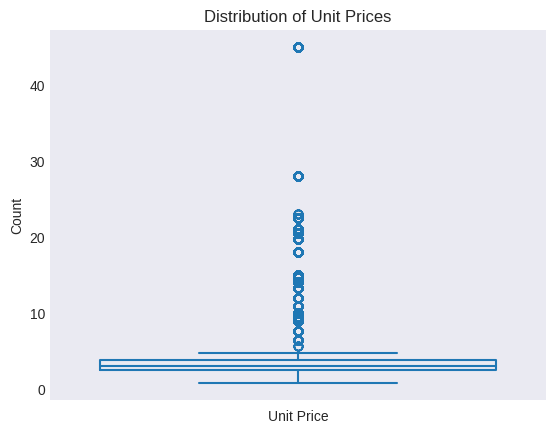

In [102]:
# Generate the box plot for the 'unit_price' column
sns.boxplot(coffee_sales["unit_price"], fill=False)
plt.title("Distribution of Unit Prices")
plt.ylabel("Count")
plt.xlabel("Unit Price")
# Call show() to display the plot
plt.show()


To investigate the prices exceeding $25, we can filter the corresponding records and check which products have these extreme prices.

In [103]:
# Filter products with a unit price greater than or equal to 25 dollars and group by quantity
coffee_sales[coffee_sales["unit_price"] >= 25]["product_type"].value_counts()

,count
product_type,
Clothing,216
Premium Beans,190
Organic Beans,17


In [104]:
# Filter products with a unit price greater than or equal to 25 and with product type "Clothing"
# Then, get the unique values in the 'product_detail' column
coffee_sales[(coffee_sales["unit_price"] >= 25) & (coffee_sales["product_type"] == "Clothing")]["product_detail"].unique()

array(['I Need My Bean! T-shirt'], dtype=object)

It's clear that the high-priced products are premium and organic coffee bean bags, as well as clothing items with the store's branding.

For the next step, let's investigate the minimum prices in the store.

In [105]:
# Get the minimum value of the unit price in the "unit_price" column
coffee_sales["unit_price"].min()

0.8


To find out which category and product type corresponds to the minimum price of $0.80, you can filter the dataset based on the minimum price.

In [106]:
# Filter products with a unit price of exactly 0.8 and count the number of products in each category
coffee_sales[coffee_sales["unit_price"] == 0.8]["product_category"].value_counts()


,count
product_category,
Flavours,6790


In [107]:
# Filter products with a unit price of 0.8 and product category "Flavours", then count by product type
coffee_sales[
    (coffee_sales["unit_price"] == 0.8)
    &
    (coffee_sales["product_category"] == "Flavours")
]["product_type"].value_counts()

,count
product_type,
Regular syrup,4979
Sugar free syrup,1811


As we can see, syrups are the products with the minimum price in the store, costing $0.80. This suggests that the syrups in the "Flavours" category are the least expensive items in the dataset.

### Visual Analysis of the categories of the Dataset

#### Categories

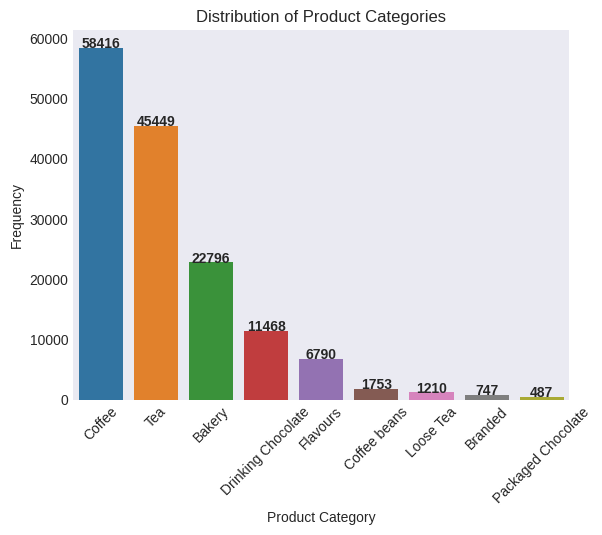

In [108]:
# Count the number of products in each category and reset the index to structure it as a DataFrame
product_category_count = coffee_sales["product_category"].value_counts().reset_index()

# Create a bar chart with Seaborn
ax = sns.barplot(
    x=product_category_count["product_category"],  # Product category on the X-axis
    y=product_category_count["count"],  # Frequency on the Y-axis
    hue=product_category_count["product_category"],  # Color by category
)

# Add numerical labels above each bar for better value visualization
for i, value in enumerate(product_category_count["count"]):
    ax.text(i, value + 0.5, str(value), ha="center", fontsize=10, fontweight="bold")

# Add title and labels to the axes
plt.title("Distribution of Product Categories")
plt.xlabel("Product Category")
plt.ylabel("Frequency")

# Rotate X-axis labels for better visibility
plt.xticks(rotation=45)

# Show the chart
plt.show()


In order to interpret the distribution and corresponding percentages, a function will be declared to calculate the percentages of the total accumulated sales.


In [109]:
def percentage_category(category, df, column, total):
    """
    Calculates the percentage of a specific category within a Pandas DataFrame.

    Args:
        category: The value to search for in the specified column.
        df: The Pandas DataFrame to search within.
        column: The name of the column to search in.
        total: The total value to calculate the percentage against.

    Returns:
        The percentage of the category rounded to 2 decimal places, or an error
        message if the DataFrame is invalid or unprocessed.
    """
    try:
        value = df[df[column] == category]["count"].values[0]
        return round((value / total) * 100, 2)
    except:
        return "invalid or unprocessed dataframe"

In [110]:
# Define a list with the product categories to analyze
product_category = [
    "Bakery",              # Baked goods
    "Packaged Chocolate",  # Packaged chocolates
    "Coffee",              # Coffee
    "Tea",                 # Tea
    "Branded"              # Branded products
]

# Calculate the total number of products in all categories by summing the frequencies
total_categories = product_category_count.sum().values[1]

In [111]:
# Iterate over each product category in the product_category list
for cat in product_category:
    # Calculate the sales percentage of the current category and display the result
    print(f"{cat}: {percentage_category(cat, product_category_count, 'product_category', total_categories)} % of total sales")

Bakery: 15.29 % of total sales
Packaged Chocolate: 0.33 % of total sales
Coffee: 39.17 % of total sales
Tea: 30.48 % of total sales
Branded: 0.5 % of total sales


This plot shows us the distribution of cafeteria sales by product category. We can see that the products in the Coffee and Tea categories dominate total sales, which indicates that these products are the customers' favorites. Coffee makes up almost two-fifths of total sales, with a specific figure of 39.17% of total sales, and tea has 30.48% of corresponding sales. Baked goods are in third place, representing 15.29% of total sales, which, despite being a secondary category, represents an important part of the revenue.

Among the products with the lowest sales, we can see that packaged chocolates represent just 0.33% of total sales, followed by products with the store logo at 0.5% of accumulated sales.


#### Types

To analyze the product type, it will first be necessary to check the size of the set of unique product types.

In [112]:
# Calculate the total number of unique product types in the dataset
len(coffee_sales["product_type"].unique())

29

Considering the size of the data set, the store's products will be explored by plotting the 5 best-selling and the 5 least-selling products.

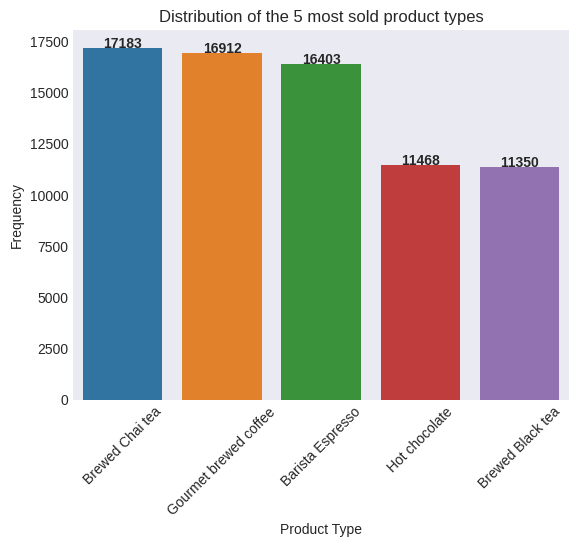

In [113]:
# Count the number of products in each Type and reset the index to structure it as a DataFrame
product_type_count_top5 = coffee_sales["product_type"].value_counts().reset_index().head()

# Create a bar chart with Seaborn
ax = sns.barplot(
    x=product_type_count_top5["product_type"],  # Product type on the X-axis
    y=product_type_count_top5["count"],  # Frequency on the Y-axis
    hue=product_type_count_top5["product_type"],  # Color by Type
)

# Add numerical labels above each bar for better value visualization
for i, value in enumerate(product_type_count_top5["count"]):
    ax.text(i, value + 0.5, str(value), ha="center", fontsize=10, fontweight="bold")

# Add title and labels to the axes
plt.title("Distribution of the 5 most sold product types")
plt.xlabel("Product Type")
plt.ylabel("Frequency")

# Rotate X-axis labels for better visibility
plt.xticks(rotation=45)

# Show the chart
plt.show()


This plot confirms the best-selling categories of coffee and tea, as within the 5 best-selling products in the cafeteria we can see that 2 of them correspond to coffee variants and 3 of them correspond to tea variants, respectively, and showing a preference for hot chocolate for a large part of the sales.

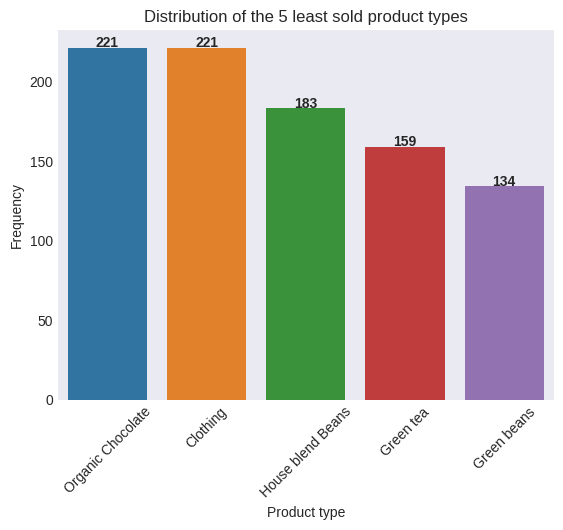

In [114]:
# Count the number of products in each type and reset the index to structure it in a DataFrame
product_type_count_bottom5 = coffee_sales["product_type"].value_counts().reset_index().tail()

# Create a bar chart with Seaborn
ax = sns.barplot(
    x=product_type_count_bottom5["product_type"],  # Product type on the X axis
    y=product_type_count_bottom5["count"],  # Frequency on the Y axis
    hue=product_type_count_bottom5["product_type"],  # Color by type
)

# Add numeric labels above each bar to better visualize the values
for i, value in enumerate(product_type_count_bottom5["count"]):
    ax.text(i, value + 0.5, str(value), ha="center", fontsize=10, fontweight="bold")

# Add title and labels to the axes
plt.title("Distribution of the 5 least sold product types")
plt.xlabel("Product type")
plt.ylabel("Frequency")

# Rotate the labels on the X axis for better visibility
plt.xticks(rotation=45)

# Show the chart
plt.show()

This plot shows the distribution of the 5 least-selling products in the store. Noticing that two types of beans ("House Blend Beans" and "Green Beans"), as well as green tea, make up a different category from the least-selling ones, we could analyze if their low demand is due to a niche strategy, high prices, or simply a lower customer preference.

With the presence of chocolate and the cafeteria's branded products, it opens the door to further analysis to identify the factors that cause these products to have low sales and, if possible, find an area for improvement.

### Exploring Temporal Sales Trends

####Monthly sales by location

To visually analyze sales data over time, the first step is to aggregate it to obtain sales by month, hour, day and week. In this initial phase, sales will be explored by store location.

In [ ]:
# Define the columns to be used in the analysis
columns = ['transaction_timestamp', 'product_category', 'store_location']

# ----------------------------------------------
# Sales analysis by store and month
# ----------------------------------------------
monthly_sales_per_store = (
    coffee_sales[columns]  # Select only the relevant columns
    .assign(
        # Extract the transaction month and year in "MM YYYY" format
        month=lambda x: x['transaction_timestamp'].dt.strftime('%m %Y')
    )
    # Group data by store location and month
    .groupby(['store_location', 'month'])
    .size()  # Count the number of transactions in each group
    .reset_index(name='count')  # Convert the result into a DataFrame with a column named 'count'
)

# ----------------------------------------------
# Sales analysis by store and day of the week
# ----------------------------------------------
daily_sales_per_store = (
    coffee_sales[columns]  # Select only the relevant columns
    .assign(
        # Extract the day of the week in full text format (e.g., "Monday", "Tuesday", etc.)
        day=lambda x: x['transaction_timestamp'].dt.strftime('%A')
    )
    # Group data by store location and day of the week
    .groupby(['store_location', 'day'])
    .size()  # Count the number of transactions in each group
    .reset_index(name='count')  # Convert the result into a DataFrame with a column named 'count'
)

# ----------------------------------------------
# Sales analysis by store and hour of the day
# ----------------------------------------------
hourly_sales_per_store = (
    coffee_sales[columns]  # Select only the relevant columns
    .assign(
        # Extract the transaction hour in 24-hour format (e.g., "08", "15", "23")
        hour=lambda x: x['transaction_timestamp'].dt.strftime('%H')
    )
    # Group data by store location and hour of the day
    .groupby(['store_location', 'hour'])
    .size()  # Count the number of transactions in each group
    .reset_index(name='count')  # Convert the result into a DataFrame with a column named 'count'
)
# ----------------------------------------------
# Sales Analysis by Store and Week
# ----------------------------------------------

weekly_sales_per_store = (
    coffee_sales[columns]  # Select only relevant columns
    .assign(
        # Extract the week number from the transaction date
        week=lambda x: x['transaction_timestamp'].dt.strftime('%W')
    )
    # Group data by store location and week number
    .groupby(['store_location', 'week'])
    .size()  # Count the number of transactions in each group
    .reset_index(name='count')  # Convert the result into a DataFrame with a 'count' column
)


In [ ]:
# Create a line plot to visualize monthly sales by store location
sns.lineplot(
    x=monthly_sales_per_store["month"],  # X-axis: Months
    y=monthly_sales_per_store["count"],  # Y-axis: Number of sales
    hue=monthly_sales_per_store["store_location"]  # Differentiate by store location
)

# Axis labels and chart title
plt.xlabel("Month")  # X-axis label
plt.ylabel("Sales")  # Y-axis label
plt.legend(title="Store location") # Legend title
plt.title("Monthly Sales by Store Location")  # Chart title

# Display the plot
plt.show()


The chart shows the sales trend during the first half of 2023. We can see that the year started with a downward trend, which, by the end of February, began to rise until the data cutoff month. We can observe that the Astoria and Hell's Kitchen locations have similar sales trends, with Lower Manhattan showing a small difference in sales.

####Daily sales by location

In [ ]:
# Sort daily sales per store in ascending order by the number of sales
daily_sales_per_store = daily_sales_per_store.sort_values(by="count")

# Create a line plot to visualize sales by day and store
sns.lineplot(
    x=daily_sales_per_store["day"],  # X-axis: Day
    y=daily_sales_per_store["count"],  # Y-axis: Number of sales
    hue=daily_sales_per_store["store_location"]  # Differentiate by store location
)

# Axis labels and chart title
plt.xlabel("Day")  # X-axis label
plt.ylabel("Sales")  # Y-axis label
plt.legend(title="Store Location")  # Legend title
plt.title("Sales by Day and Store")  # Chart title

# Display the chart
plt.show()


####Hourly sales by location

In [ ]:
# Sort hourly sales per store in ascending order by hour
hourly_sales_per_store = hourly_sales_per_store.sort_values(by="hour")

# Create a line plot to visualize sales by hour and store
sns.lineplot(
    x=hourly_sales_per_store["hour"],  # X-axis: Hour
    y=hourly_sales_per_store["count"],  # Y-axis: Number of sales
    hue=hourly_sales_per_store["store_location"]  # Differentiate by store location
)

# Axis labels and chart title
plt.xlabel("Hour")  # X-axis label
plt.ylabel("Sales")  # Y-axis label
plt.legend(title="Store Location")  # Legend title
plt.title("Sales by Hour and Store")  # Chart title

# Display the chart
plt.show()


####Weekly sales by location

In [ ]:
# Sort weekly sales per store in ascending order by week
weekly_sales_per_store = weekly_sales_per_store.sort_values(by="week")

# Create a line plot to visualize sales by week and store
sns.lineplot(
    x=weekly_sales_per_store["week"],  # X-axis: Week
    y=weekly_sales_per_store["count"],  # Y-axis: Number of sales
    hue=weekly_sales_per_store["store_location"]  # Differentiate by store location
)

# Axis labels and chart title
plt.xlabel("Week")  # X-axis label
plt.ylabel("Sales")  # Y-axis label
plt.legend(title="Store Location")  # Legend title
plt.title("Weekly Sales by Store")  # Chart title

# Display the chart
plt.show()


Based on these graphs, we can confirm the presence of seasonality in the data, with higher sales volumes observed on Thursdays and Fridays. Additionally, the highest sales frequency occurs between 7:00 a.m. and 10:00 a.m., after which the volume begins to decline.

Taking the seasonality of sales into account, we will proceed to train the predictive model with the necessary adjustments.

## 3. Model Training

#### Dataset Preparation

To train the model, we will create a copy of the original DataFrame, filtering the necessary columns, which in this case are the sale date and the unit price of the product. We will also separate the data by store, and the data will be aggregated by day.

In [ ]:
def daily_sales(df_store):
    daily = (df_store
          .set_index('ds')        # date column
          .resample('D')['y'].sum()              # daily sales
          .asfreq('D', fill_value=0)
          .reset_index())


    return daily

In [ ]:
# We make a copy of the original DataFrame to avoid modifying the original data
df_train_manhattan = coffee_sales.copy()
df_train_hell_kitchen = coffee_sales.copy()
df_train_astoria = coffee_sales.copy()


In [ ]:

# We filter only the necessary columns: sale date and unit price
df_train_manhattan = df_train_manhattan[df_train_manhattan['store_location'] == 'Lower Manhattan'][["transaction_timestamp", "unit_price"]]
df_train_hell_kitchen = df_train_hell_kitchen[df_train_hell_kitchen["store_location"] == "Hell's Kitchen"][["transaction_timestamp", "unit_price"]]
df_train_astoria = df_train_astoria[df_train_astoria["store_location"] == 'Astoria'][["transaction_timestamp", "unit_price"]]

# We rename the columns to be compatible with Prophet:
df_train_manhattan.columns = ['ds', 'y']
df_train_hell_kitchen.columns = ['ds', 'y']
df_train_astoria.columns = ['ds', 'y']


In [ ]:
df_train_manhattan = daily_sales(df_train_manhattan)
df_train_hell_kitchen = daily_sales(df_train_hell_kitchen)
df_train_astoria = daily_sales(df_train_astoria)

####Model Initialization

To find the best fit for the model, a function is created to iterate over a list of parameters in order to identify the optimal configuration. Afterwards, cross-validation is performed to evaluate the model's performance, using MAPE as the key metric.

In [ ]:
def best_fit(df):
    # Define a grid of parameters to tune: changepoint scale, seasonality scale, and Fourier order for weekly seasonality
    param_grid = {
        'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],  # Controls model flexibility to fit abrupt changes
        'seasonality_prior_scale': [1, 5, 10],               # Controls the strength of seasonalities
        'fourier_order': [3, 5, 7]                           # Number of Fourier terms to capture weekly seasonality
    }

    # Generate 10 random combinations of the defined parameters
    param_combinations = [
        {
            'changepoint_prior_scale': random.choice(param_grid['changepoint_prior_scale']),
            'seasonality_prior_scale': random.choice(param_grid['seasonality_prior_scale']),
            'fourier_order': random.choice(param_grid['fourier_order'])
        }
        for _ in range(10)
    ]

    results = []  # List to store the results of each combination

    # Evaluate each parameter combination
    for params in param_combinations:
        # Create a Prophet model with the selected parameters
        model = Prophet(
            changepoint_prior_scale=params['changepoint_prior_scale'],
            seasonality_prior_scale=params['seasonality_prior_scale'],
            weekly_seasonality=False  # Disable default weekly seasonality
        )

        # Manually add a stronger weekly seasonality
        model.add_seasonality(
            name='strong_weekly',
            period=7,  # 7-day seasonality
            fourier_order=params['fourier_order']
        )

        # Train the model with the data
        model.fit(df)

        # Perform time series cross-validation:
        # - initial training period: 120 days
        # - make predictions every 15 days
        # - prediction horizon: 30 days
        df_cv = cross_validation(model, initial='120 days', period='15 days', horizon='30 days', parallel="processes")

        # Compute evaluation metrics like MAPE
        df_perf = performance_metrics(df_cv)

        # Take the average MAPE for this combination
        mape = df_perf['mape'].mean()

        # Store the combination and its associated MAPE
        results.append((params, mape))

    # Sort results by MAPE in ascending order
    results.sort(key=lambda x: x[1])

    # Print the best combination and its MAPE
    return(print("Best combination:", results[0][0], "MAPE:", results[0][1]))

The previously defined function is called to obtain the best-fitting values for the model based on the sales of each store location.

In [ ]:
best_fit(df_train_manhattan)

For the **Manhattan** store, the best calculated combination is:

*  **changepoint_prior_scale**: 0.01

* **seasonality_prior_scale**: 1

* **fourier_order**: 3

* With a **MAPE** of 12.14%.

In [ ]:
best_fit(df_train_hell_kitchen)

For the **Hell's Kitchen** store, the best calculated combination is:

* **changepoint_prior_scale**: 0.01

* **seasonality_prior_scale**: 10

* **fourier_order**: 7

* With a **MAPE** of 16.32%.

In [ ]:
best_fit(df_train_astoria)

For the **Astoria** store, the best calculated combination is:

* **changepoint_prior_scale**: 0.01

* **seasonality_prior_scale**: 5

* **fourier_order**: 5

* With a **MAPE** of 12.95%.

The model is initialized including the previously observed seasonality.

In [ ]:
model_manhattan = Prophet(
    changepoint_prior_scale=0.01,
    seasonality_prior_scale= 1,
    daily_seasonality=True,
    weekly_seasonality=False
)

model_manhattan.add_seasonality(
    name='weekly_strong',
    period=7,
    fourier_order=3
)

model_manhattan.add_country_holidays(country_name='US')

In [ ]:
model_hell_kitchen = Prophet(
    changepoint_prior_scale=0.01,
    seasonality_prior_scale = 10,
    daily_seasonality=True,
    weekly_seasonality=False
)

model_hell_kitchen.add_seasonality(
    name='weekly_strong',
    period=7,
    fourier_order=7
)

model_hell_kitchen.add_country_holidays(country_name='US')

In [ ]:
model_astoria = Prophet(
    changepoint_prior_scale=0.01,
    daily_seasonality=True,
    weekly_seasonality=False,
    seasonality_prior_scale=5
)

model_astoria.add_seasonality(
    name='weekly_strong',
    period=7,
    fourier_order=5
)

model_astoria.add_country_holidays(country_name='US')

The model is fitted using the previously generated DataFrame.

In [ ]:
model_manhattan.fit(df_train_manhattan)

In [ ]:
model_hell_kitchen.fit(df_train_hell_kitchen)

In [ ]:
model_astoria.fit(df_train_astoria)

## Model Cross validation

We applied cross-validation to the forecasting models for Lower Manhattan, Hell’s Kitchen, and Astoria, using an initial training window of 120 days, a rolling period of 15 days, and a forecast horizon of 30 days. The performance of each model was evaluated with metrics such as MAPE, and the results were consolidated into a single DataFrame with the corresponding location labels for comparison.

In [ ]:
df_cv_manhattan = cross_validation(model_manhattan, initial='120 days', period='15 days', horizon='30 days', parallel="processes")
# Compute evaluation metrics like MAPE
df_perf_manhattan = performance_metrics(df_cv_manhattan)


df_cv_hell_kitchen = cross_validation(model_hell_kitchen, initial='120 days', period='15 days', horizon='30 days', parallel="processes")
# Compute evaluation metrics like MAPE
df_perf_hell_kitchen = performance_metrics(df_cv_hell_kitchen)

df_cv_astoria = cross_validation(model_astoria, initial='120 days', period='15 days', horizon='30 days', parallel="processes")
# Compute evaluation metrics like MAPE
df_perf_astoria = performance_metrics(df_cv_astoria)



In [ ]:
df_perf = pd.DataFrame()
# Iterate over a list of tuples, each containing a perfomance DataFrame and its corresponding location name.
for df, val in [
  (df_perf_manhattan, " Lower Manhattan"),
  (df_perf_hell_kitchen, "Hell Kitchen"),
  (df_perf_astoria, "Astoria")]:

  # Add a new column called 'Location' with the corresponding location name.
  df['Location'] = val
  # Combine (concatenate) the three perfomance DataFrames into a single one by stacking them vertically.
  df_perf = pd.concat([df_perf, df])

## Forescast

The forecast is initialized for the next 30 days starting from the last date in the model for each store.

In [ ]:
# Generate a DataFrame of future dates starting from the end of the original dataset.
# 'periods=30' indicates that 30 additional days will be generated.
future_manhattan = model_manhattan.make_future_dataframe(periods=30)
future_hell_kitchen = model_hell_kitchen.make_future_dataframe(periods=30)
future_astoria = model_astoria.make_future_dataframe(periods=30)

# Use the already trained model (model_manhattan) to make predictions
# for the dates in the generated DataFrame. The result is a DataFrame
# with columns such as 'ds' (date), 'yhat' (prediction), 'yhat_lower' and 'yhat_upper' (confidence interval).
forecast_manhattan = model_manhattan.predict(future_manhattan)
forecast_hell_kitchen = model_hell_kitchen.predict(future_hell_kitchen)
forecast_astoria = model_astoria.predict(future_astoria)

In [ ]:
forescast_df = pd.DataFrame()
# Iterate over a list of tuples, each containing a forecast DataFrame and its corresponding location name.
for df, val in [
  (forecast_manhattan_future, " Lower Manhattan"),
  (forecast_hell_kitchen_future, "Hell Kitchen"),
  (forecast_astoria_future, "Astoria")]:

  # Add a new column called 'Location' with the corresponding location name.
  df['Location'] = val
  # Combine (concatenate) the three forecast DataFrames into a single one by stacking them vertically.
  forescast_df = pd.concat([forescast_df, df])

## Import to PostgreSQL Database

To establish a secure connection to the PostgreSQL database, environment variables are used to manage the credentials and connection parameters, thus avoiding exposing sensitive information in the code.

In [ ]:
# Load environment variables from a .env file to retrieve database credentials.
load_dotenv()
USER = os.getenv("user")
PASSWORD = os.getenv("password")
HOST = os.getenv("host")
PORT = os.getenv("port")
DBNAME = os.getenv("dbname")

# Build the PostgreSQL connection URL using the psycopg2 driver, including SSL for enhanced security.
DATABASE_URL = f"postgresql+psycopg2://{USER}:{PASSWORD}@{HOST}:{PORT}/{DBNAME}?sslmode=require"

# Create a connection engine using SQLAlchemy.
engine = create_engine(DATABASE_URL)

# Attempt to connect to the database and print a success or error message.
try:
    with engine.connect() as connection:
        print("Successful connection")
except Exception as e:
    print(f"Connection failed \n error: {e}")


The DataFrames `forescast_df` and coffee_sales are exported to the PostgreSQL database using pandas `to_sql` method. Each DataFrame is saved in a specific table (`'forescast'` and `'coffe_sales'`, respectively).

In [ ]:
# Export the 'forescast_df' DataFrame to the 'forescast' table in the database.
# If the table exists, it will be replaced; the DataFrame index is not saved as a column.
forescast_df.to_sql('forescast', con=engine, if_exists='replace', index=False)

# Export the 'coffee_sales' DataFrame to the 'coffe_sales' table in the database.
# It also replaces the table if it exists and does not save the index.
coffee_sales.to_sql('coffe_sales', con=engine, if_exists='replace', index=False)

# Export the perfomance DataFrame to the 'perfomance' table in the database.
# It also replaces the table if it exists and does not save the index.
df_perf.to_sql('perfomance', con=engine, if_exists='replace', index=False)

#Español

##1. Introducción


En este proyecto, se realizó un análisis exploratorio de datos (EDA) y un modelo de predicción de ventas basado en series temporales usando un conjunto de datos disponible en este [enlace](https://www.kaggle.com/datasets/ahmedabbas757/coffee-sales) de Kaggle.

El Objetivo principal de este proyecto es comprender los patrones históricos de ventas y poder desarrollar un modelo de aprendizaje automático que pueda anticipar el comportamiento futuro para poder proporcionar información valiosa para para la toma de decisiones.

El flujo de trabajo incluyó las siguientes etapas principales:


1.   **Extracción de los datos de Kaggle usando una Api**:
    Se uso la API Kagglehub para poder extraer los datos de manera correcta y poder mantenerlos actualizados si existe un cambio en el origen de los datos.
2.   **Análisis Exploratorio de Datos (EDA)**:
    Se utilizó Python y bibliotecas como pandas, matplotlib y seaborn para limpiar y analizar el conjunto de datos, identificando tendencias, estacionalidad y variables clave que afectan las ventas, así como para visualizar los datos de manera rápida.
3. **Modelado Predictivo de aprendizaje automatico**:
    Se implementó el modelo de pronóstico Prophet desarrollado por Facebook para predecir ventas futuras, considerando aspectos como tendencias y eventos estacionales.
4. **Visualización en Power BI**:
    Los datos y resultados obtenidos se integraron en un tablero interactivo en Power BI, facilitando la comunicación de insights de manera visual e intuitiva.

El proyecto busca demostrar habilidades técnicas en análisis de datos, modelado predictivo y creación de visualizaciones dinámicas, así como la capacidad de trabajar con herramientas modernas de ciencia de datos y análisis empresarial. Este enfoque es crucial para extraer valor de los datos y apoyar la toma de decisiones basadas en evidencia.





---



## 2. Desarrollo del proyecto

En esta sección, se detallará paso a paso el proceso seguido para desarrollar el análisis y la predicción de las ventas, desde la configuración del entorno y la preparación de los datos, hasta la implementación del modelo y la visualización final.

### Importación de las librerías

El primer paso fue importar las librerías necesarias para llevar a cabo el análisis y modelado. Se utilizaron herramientas estándar de Python que son ampliamente reconocidas en la comunidad de ciencia de datos, así como herramientas de visualización de datos, la libería de Kagglehub para la extracción de los datos y Prophet, para el desarrollo del modelo.

In [ ]:
# Librerías para la manipulación, manejo  y análisis de datos
import pandas as pd
import numpy as np

# Librería para extracción de datos desde Kaggle
import kagglehub
import os

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para el modelo basado en series temporales
from prophet import Prophet
from prophet.diagnostics import performance_metrics, cross_validation
import random


# Librería para conectar con bases de datos SQL
from sqlalchemy import create_engine

# Librería para cargar variables de entorno desde un archivo .env
from dotenv import load_dotenv

# ILibrería para acceder a las variables de entorno cargadas
import os

# Manejo de advertencias
import warnings
warnings.filterwarnings("ignore")

# Configuración del estilo de las visualizaciones
plt.style.use('seaborn-v0_8-dark')

random.seed(24)


### Extracción de los Datos

Para garantizar que el análisis se base en información al día, se utilizó la librería kagglehub para descargar los datos directamente desde Kaggle, esto permite tener un enfoque en un flujo de trabajo dinámico y flexible, ya que la información se puede sincronizar fácilmente en caso de existir actualizaciones en el conjunto de datos.

In [ ]:
# Se descarga el conjunto de datos desde Kaggle
path = kagglehub.dataset_download("ahmedabbas757/coffee-sales")

# Nombre del archivo descargado
file_name = "Coffee Shop Sales.xlsx"

# Se construye la ruta completa del archivo
file_path = os.path.join(path, file_name)

# Se carga el archivo a un DataFrame de pandas.
coffee_sales = pd.read_excel(file_path)

### Análisis Exploratorio de Datos (EDA)

Una vez cargados los datos en un DataFrame, es fundamental realizar una exploración inicial para comprender su estructura y calidad de los datos usando el método info(), este nos proporciona una vista general de los datos para ver información clave sobre la estructura de los datos.

In [ ]:
coffee_sales.info()

Podemos ver que los datos están organizados por un identificador de transacción, el cual está acompañado de información importante como la fecha de la transacción, la cantidad vendida, la ubicación de la tienda y características del producto, como su precio unitario, categoría y tipo.
Además de estos detalles, se cuenta con un total de 149,116 filas, y lo más relevante es que ninguna de ellas contiene datos nulos. Un aspecto adicional a destacar es que la fecha y la hora de la transacción están separadas en columnas distintas.



### Transformación de las columnas de fecha y hora

Dado que la fecha y la hora de la transacción se encuentran separadas en columnas distintas (`transaction_date` y `transaction_time`), el objetivo de este paso es combinarlas en una sola columna con un formato de timestamp (fecha y hora) para facilitar el análisis temporal.

In [ ]:
# Se concadenan las columnas 'transaction_date' y 'transaction_time' en una sola columna llamada 'transaction_timestamp'
# Primero, se convierte ambas columnas a tipo cadena (str) y se unen con un espacio en medio
coffee_sales["transaction_timestamp"] = coffee_sales["transaction_date"].astype(str) + ' ' + coffee_sales["transaction_time"].astype(str)

# Se convierte la columna nueva 'transaction_timestamp' a tipo datetime para facilitar el análisis temporal
coffee_sales["transaction_timestamp"] = pd.to_datetime(coffee_sales["transaction_timestamp"])

# Se eliminan las columnas originales 'transaction_date' y 'transaction_time'
coffee_sales.drop(["transaction_date", "transaction_time"], axis=1, inplace=True)

Para verificar que la nueva columna es correcta, podemos comprobar los datos mostrando las primeras filas y asegurándonos de que la columna transaction_timestamp contiene el formato datetime esperado.


In [ ]:
coffee_sales["transaction_timestamp"].head()

### Verificación de duplicados en las transacciones

Para asegurarnos de que cada transacción es única, se compara el número de registros originales del conjunto de datos con el número de identificadores únicos en la columna `transaction_id`. Si ambos valores son iguales, significa que no hay transacciones duplicadas; de lo contrario, existen registros repetidos en los datos.



In [ ]:
# Eliminar valores duplicados en la columna 'transaction_id' y contar cuántos identificadores únicos existen
unique_transactions = coffee_sales["transaction_id"].drop_duplicates().shape[0]

# Contar el número total de filas en el DataFrame original
total_transactions = coffee_sales.shape[0]

# Comparar si el número de identificadores únicos es igual al número total de filas en el DataFrame
# Si es True, significa que cada transacción tiene un identificador único y no hay duplicados
# Si es False, significa que existen transacciones con el mismo 'transaction_id' más de una vez
unique_transactions == total_transactions

### Verificación de las ubicaciones de las tiendas

Para analizar la distribución de las transacciones por tienda, el siguiente código cuenta la frecuencia de ocurrencia de cada combinación única de `store_location` y `store_id`. Esto permite identificar cuántas transacciones se realizaron en cada tienda y detectar posibles inconsistencias en los datos, como tiendas con múltiples identificadores o ubicaciones duplicadas.

In [ ]:
# Contar la frecuencia de combinaciones únicas de 'store_location' y 'store_id'
coffee_sales[["store_location", "store_id"]].value_counts()


El resultado muestra el número de transacciones registradas en cada combinación de `store_location` y `store_id`. Por ejemplo, la tienda en *Hell’s Kitchen* con el ID **8** tuvo **50,735** transacciones, mientras que la ubicada en *Astoria* con el ID **3** registró **50,599** ventas. De manera similar, la tienda en *Lower Manhattan* con el ID **5** acumuló **47,782** transacciones.

### Normalización de valores en los detalles de los productos

Para verificar que el conjunto de datos no tenga incosistencias en la columna `product_detail`, como pueden ser las variaciones en las mayúsculas o minúsculas, espacios adicionales en medio de las oraciones, al principio o final de estas.

Para lograr esto, se va a comparar el tamaño del dataset filtrado por valores únicos antes y después de una normalización de los datos eliminando los espacios extras, asi como convirtiendo el texto a minúsculas.

In [ ]:
# Imprimir el número de valores únicos antes de la validación
print(f"Numero de valores antes de la validación: {coffee_sales['product_detail'].value_counts().shape[0]}")

# Imprimir el número de valores únicos después de aplicar la validación (normalización de espacios, minúsculas y strip)
print("Numero de valores después de la validación: ",
      coffee_sales['product_detail'].str.replace(r'\s+', ' ', regex=True).str.lower().str.strip().value_counts().shape[0])



Como la cantidad de valores únicos se mantuvo igual antes y después de la normalización, podemos concluir que estos datos no requieren correcciones.



### Revisar si no hay valores extremos en los precios unitarios

Para poder revisar si hay valores extremos en los precios unitarios, se ejecutara un codigo que nos permita generar un gráfico de caja para poder ver visualmente la distribución de los valores. Este gráfico nos ayudará a identificar los valores extremos que puedan existir fuera del rango intercuartílico (IQR).

In [ ]:
#Se genera el gráfico con la columna unit_price
sns.boxplot(coffee_sales["unit_price"], fill=False)
plt.title("Distribución de los precios unitarios")
plt.xlabel("Precio unitario")
plt.ylabel("Frecuencia")
#se llama show() para mostrar el gráfico
plt.show()

Podemos ver en el gráfico precios que sobrepasan los $25 doláres, para investigarlo vamos a ejecutar el siguente código.

In [ ]:
# Filtrar los productos cuyo precio unitario es mayor o igual a 25 doláres y agrupar por cantidad.
coffee_sales[coffee_sales["unit_price"]>=25]["product_type"].value_counts()

In [ ]:
# Filtrar los productos cuyo precio unitario es mayor o igual a 25 y cuyo tipo de producto es "Clothing"
# Y  obtener los valores únicos
coffee_sales[(coffee_sales["unit_price"]>=25)&(coffee_sales["product_type"]== "Clothing")]["product_detail"].unique()

Podemos ver que estos productos con precios altos son bolsas de granos de café premium y orgánicos, así como piezas de ropa con el branding de la tienda.

Para el siguiente paso se van a investigar los precios mínimos de la tienda.

In [ ]:
# Obtener el valor mínimo del precio unitario en la columna "unit_price"
coffee_sales["unit_price"].min()

Podemos ver un precio mínimo de $0.8 doláres, para ver a que categoría y tipo de producto, se va a ejecutar el siguiente código.

In [ ]:
# Se van a filtrar los productos cuyo precio unitario es exactamente 0.8
# y se van a contar la cantidad de productos en cada categoría.
coffee_sales[coffee_sales["unit_price"]==0.8]["product_category"].value_counts()

In [ ]:
# Filtrar los productos cuyo precio unitario es 0.8 y cuya categoría de producto es "Flavours" y contar por categoria
coffee_sales[
    (coffee_sales["unit_price"]==0.8)
    &
    (coffee_sales["product_category"]== "Flavours")
    ]["product_type"].value_counts()

Como podemos ver, los jarabes son los productos con el precio mínimo en la tienda con un costo de $0.8 doláres.

### Exploración visual de las categorías del conjunto de datos

#### Categorías

In [ ]:
# Contar la cantidad de productos en cada categoría y reiniciar el índice para estructurarlo en un DataFrame
product_category_count = coffee_sales["product_category"].value_counts().reset_index()

# Crear un gráfico de barras con Seaborn
ax = sns.barplot(
    x=product_category_count["product_category"],  # Categoría de producto en el eje X
    y=product_category_count["count"],  # Frecuencia en el eje Y
    hue=product_category_count["product_category"],  # Colorear por categoría
)

# Agregar etiquetas numéricas encima de cada barra para visualizar mejor los valores
for i, value in enumerate(product_category_count["count"]):
    ax.text(i, value + 0.5, str(value), ha="center", fontsize=10, fontweight="bold")

# Agregar título y etiquetas a los ejes
plt.title("Distribución de las categorías de productos")
plt.xlabel("Categoría de producto")
plt.ylabel("Frecuencia")

# Rotar las etiquetas del eje X para mejor visibilidad
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.show()

Para poder interpretrar la distribución y los porcentajes correspondientes, se declará una función que nos permita calcular los porcentajes del total de las ventas acomuladas.

In [ ]:
def percentage_category(category, df, column, total):
    """
    Calcula el porcentaje de una categoría específica dentro de un DataFrame de Pandas.

    Args:
        category: El valor a buscar en la columna especificada.
        df: El DataFrame de Pandas en el que se buscará.
        column: El nombre de la columna en la que se buscará.
        total: El valor total contra el que se calculará el porcentaje.

    Returns:
        El porcentaje de la categoría redondeado a 2 decimales, o un mensaje de error
        si el DataFrame no es válido o no ha sido procesado.
    """
    try:
        value = df[df[column] == category]["count"].values[0]
        return round((value / total) * 100, 2)
    except:
        return "dataframe no válido o no procesado"

In [ ]:
# Definir una lista con las categorías de productos a analizar
product_category = [
    "Bakery",              # Productos horneados
    "Packaged Chocolate",  # Chocolates empaquetados
    "Coffee",              # Café
    "Tea",                 # Té
    "Branded"              # Productos de marca
]

# Calcular el total de productos en todas las categorías sumando las frecuencias
total_categories = product_category_count.sum().values[1]

In [ ]:
# Iterar sobre cada categoría de producto en la lista product_category
for cat in product_category:
    # Calcular el porcentaje de ventas de la categoría actual y mostrar el resultado
    print(f"{cat}: {percentage_category(cat, product_category_count, 'product_category', total_categories)} % del total de las ventas")


Este gráfico nos muestra la distribución de las ventas de la cafetería por categoría de producto, podemos ver que los productos de las categorías *Coffee y Tea* dominan en las ventas totales, lo cuál nos indica que estos productos son los productos favoritos de los clientes, siendo el café casi dos quintas partes del total de las ventas, teniendo un dato especifico del 39.17% de las ventas totales, y el té tiene un 30.48% de las ventas correspondientes. Los productos horneados se encuentran en tercer lugar, siendo un 15.29% de las ventas totales, lo cuál a pesar de ser una categoría secundaria, representan una parte importante de los ingresos.


En los productos con menos ventas, podemos ver que los chocolates enpaquetados represetan apenas un 0.33% del total de las ventas, seguidos de los productos con el logo de la tienda con el 0.5% de las ventas acomuladas.

#### Tipos

Para analizar el tipo de producto, primero se va a tener que comprobar el tamaño del conjunto de tipos de productos únicos.

In [ ]:
# Calcular el número total de tipos de productos únicos en el conjunto de datos
len(coffee_sales["product_type"].unique())

Considerando el tamaño del conjunto de los datos, se explorá los productos de tienda graficando los 5 productos más vendidos y los 5 menos vendidos.

In [ ]:
# Contar la cantidad de productos en cada Tipo y reiniciar el índice para estructurarlo en un DataFrame
product_type_count_top5 = coffee_sales["product_type"].value_counts().reset_index().head()

# Crear un gráfico de barras con Seaborn
ax = sns.barplot(
    x=product_type_count_top5["product_type"],  # Tipo de producto en el eje X
    y=product_type_count_top5["count"],  # Frecuencia en el eje Y
    hue=product_type_count_top5["product_type"],  # Colorear por Tipo
)

# Agregar etiquetas numéricas encima de cada barra para visualizar mejor los valores
for i, value in enumerate(product_type_count_top5["count"]):
    ax.text(i, value + 0.5, str(value), ha="center", fontsize=10, fontweight="bold")

# Agregar título y etiquetas a los ejes
plt.title("Distribución de los 5 tipos de productos más vendidos")
plt.xlabel("Tipo de producto")
plt.ylabel("Frecuencia")

# Rotar las etiquetas del eje X para mejor visibilidad
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.show()

Este gráfico reafirma las categorías más vendidas de café y té, pues dentro de los 5 productos más vendidos en la cafetería podemos ver que 2 de ellos corresponden a variantes de café y 3 de ellos corresponden a variantes de té, respectivamente, y mostrando una preferencia del chocolate caliente para una gran parte de las ventas.

In [ ]:
# Contar la cantidad de productos en cada Tipo y reiniciar el índice para estructurarlo en un DataFrame
product_type_count_bottom5 = coffee_sales["product_type"].value_counts().reset_index().tail()

# Crear un gráfico de barras con Seaborn
ax = sns.barplot(
    x=product_type_count_bottom5["product_type"],  # Tipo de producto en el eje X
    y=product_type_count_bottom5["count"],  # Frecuencia en el eje Y
    hue=product_type_count_bottom5["product_type"],  # Colorear por Tipo
)

# Agregar etiquetas numéricas encima de cada barra para visualizar mejor los valores
for i, value in enumerate(product_type_count_bottom5["count"]):
    ax.text(i, value + 0.5, str(value), ha="center", fontsize=10, fontweight="bold")

# Agregar título y etiquetas a los ejes
plt.title("Distribución de los 5 tipos de productos menos vendidos")
plt.xlabel("Tipo de producto")
plt.ylabel("Frecuencia")

# Rotar las etiquetas del eje X para mejor visibilidad
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.show()

En este gráfico podemos ver la distribución de los 5 productos menos vendidos en la tienda, al notar que dos tipos de granos ("House blend Beans y "Green Beans"), así como el té verde, conforman una categoría diferente a las menos vendidas, podríamos analizar si su baja demanda se debe a una estrategia de nicho, precios elevados o simplemente a una menor preferencia de los clientes.

Con la presencia del chocolate y de los productos de marca de la cafetería, da pie a un posterior analisis para identificar los factores que hacen que estos productos tengan unas ventas bajas y si es posible, encontrar un área de mejora.


### Exploración de las ventas temporales


#### Ventas Mensuales por sucursal

Para explorar los datos de forma visual a través del tiempo, se necesita primero agruparlos para obtener las ventas por mes, hora, día y semana, en este primer paso se va a explorar las ventas por surcusal.

In [ ]:
# Define the columns to be used in the analysis
columnas = ['transaction_timestamp', 'product_category', 'store_location']

# ----------------------------------------------
# Análisis de ventas por sucursal y mes
# ----------------------------------------------
ventas_por_sucursal_mensuales = (
    coffee_sales[columnas]  # Seleccionar solo las columnas relevantes
    .assign(
        # Extraer el mes y año de la fecha de transacción en formato "MM YYYY"
        month=lambda x: x['transaction_timestamp'].dt.strftime('%m %Y')
    )
    # Agrupar los datos por ubicación de la tienda y mes
    .groupby(['store_location', 'month'])
    .size()  # Contar el número de transacciones en cada grupo
    .reset_index(name='count')  # Convertir el resultado en un DataFrame con una columna llamada 'count'
)

# ----------------------------------------------
# Análisis de ventas por sucursal y día de la semana
# ----------------------------------------------
ventas_por_sucursal_diarias = (
    coffee_sales[columnas]  # Seleccionar solo las columnas relevantes
    .assign(
        # Extraer el día de la semana en formato completo (ejemplo: "Monday", "Tuesday", etc.)
        day=lambda x: x['transaction_timestamp'].dt.strftime('%A')
    )
    # Agrupar los datos por ubicación de la tienda y día de la semana
    .groupby(['store_location', 'day'])
    .size()  # Contar el número de transacciones en cada grupo
    .reset_index(name='count')  # Convertir el resultado en un DataFrame con una columna llamada 'count'
)

# ----------------------------------------------
# Análisis de ventas por sucursal y hora del día
# ----------------------------------------------
ventas_por_sucursal_por_hora = (
    coffee_sales[columnas]  # Seleccionar solo las columnas relevantes
    .assign(
        # Extraer la hora de la transacción en formato de 24 horas (ejemplo: "08", "15", "23")
        hour=lambda x: x['transaction_timestamp'].dt.strftime('%H')
    )
    # Agrupar los datos por ubicación de la tienda y hora del día
    .groupby(['store_location', 'hour'])
    .size()  # Contar el número de transacciones en cada grupo
    .reset_index(name='count')  # Convertir el resultado en un DataFrame con una columna llamada 'count'
)

# ----------------------------------------------
# Análisis de ventas por sucursal y semana
# ----------------------------------------------


ventas_por_sucursal_por_semana = (
    coffee_sales[columnas]  # Seleccionar solo las columnas relevantes
    .assign(
        # Extraer la hora de la transacción en formato de número de semana
        week=lambda x: x['transaction_timestamp'].dt.strftime('%W')
    )
    # Agrupar los datos por ubicación de la tienda y semana
    .groupby(['store_location', 'week'])
    .size()  # Contar el número de transacciones en cada grupo
    .reset_index(name='count')  # Convertir el resultado en un DataFrame con una columna llamada 'count'
)

In [ ]:
# Crear un gráfico de líneas para visualizar las ventas mensuales por sucursal
sns.lineplot(
    x=ventas_por_sucursal_mensuales["month"],  # Eje X: Meses
    y=ventas_por_sucursal_mensuales["count"],  # Eje Y: Número de ventas
    hue=ventas_por_sucursal_mensuales["store_location"]  # Diferenciar por ubicación de la tienda
)


# Etiquetas de los ejes y título del gráfico
plt.xlabel("Mes")  # Etiqueta del eje X
plt.ylabel("Ventas")  # Etiqueta del eje Y
plt.legend(title = "Ubicación de la tienda") #Titulo de la leyenda
plt.title("Ventas mensuales por sucursal")  # Título del gráfico

# Mostrar el gráfico
plt.show()


El gráfico nos muestra la tendencia de las ventas durante la primera mitad del año 2023, podemos ver que el año empezó con una tendencia a la baja que al terminar febrero, comenzó a ir a la alta hasta el mes de corte de los datos. Podemos ver que la surcusal de *Astoria* y *Hell's Kitchen* tienen tendencias similares de ventas, con Lower Manhattan teniendo una diferencia pequeña de ventas.

#### Ventas por día de la semana

In [ ]:
# Se ordena los valores de las ventas por sucursal diarias por número de ventas en forma ascedente
ventas_por_sucursal_diarias = ventas_por_sucursal_diarias.sort_values(by="count")
# Crear un gráfico de líneas para visualizar las ventas por día y sucursal
sns.lineplot(
    x=ventas_por_sucursal_diarias["day"],  # Eje X: Día
    y=ventas_por_sucursal_diarias["count"],  # Eje Y: Número de ventas
    hue=ventas_por_sucursal_diarias["store_location"]  # Diferenciar por ubicación de la tienda
)


# Etiquetas de los ejes y título del gráfico
plt.xlabel("Día")  # Etiqueta del eje X
plt.ylabel("Ventas")  # Etiqueta del eje Y
plt.legend(title = "Ubicación de la tienda") #Titulo de la leyenda
plt.title("Ventas por día y sucursal")  # Título del gráfico

# Mostrar el gráfico
plt.show()

####Ventas por hora del día

In [ ]:
# Se ordena los valores de las ventas por sucursal por número de ventas y hora  en forma ascedente
ventas_por_sucursal_por_hora = ventas_por_sucursal_por_hora.sort_values(by="hour")
# Crear un gráfico de líneas para visualizar las ventas por hora y sucursal
sns.lineplot(
    x=ventas_por_sucursal_por_hora["hour"],  # Eje X: hora
    y=ventas_por_sucursal_por_hora["count"],  # Eje Y: Número de ventas
    hue=ventas_por_sucursal_por_hora["store_location"]  # Diferenciar por ubicación de la tienda
)


# Etiquetas de los ejes y título del gráfico
plt.xlabel("Hora")  # Etiqueta del eje X
plt.ylabel("Ventas")  # Etiqueta del eje Y
plt.legend(title = "Ubicación de la tienda") #Titulo de la leyenda
plt.title("Ventas por hora y sucursal")  # Título del gráfico

# Mostrar el gráfico
plt.show()

####Ventas por semana del año

In [ ]:
# Se ordena los valores de las ventas por sucursal semanales por número de ventas en forma ascedente
ventas_por_sucursal_por_semana = ventas_por_sucursal_por_semana.sort_values(by="week")
# Crear un gráfico de líneas para visualizar las ventas por hora y sucursal
sns.lineplot(
    x=ventas_por_sucursal_por_semana["week"],  # Eje X: Semana
    y=ventas_por_sucursal_por_semana["count"],  # Eje Y: Número de ventas
    hue=ventas_por_sucursal_por_semana["store_location"]  # Diferenciar por ubicación de la tienda
)


# Etiquetas de los ejes y título del gráfico
plt.xlabel("Semana")  # Etiqueta del eje X
plt.ylabel("Ventas")  # Etiqueta del eje Y
plt.legend(title = "Ubicación de la tienda") #Titulo de la leyenda
plt.title("Ventas semanales por sucursal")  # Título del gráfico
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.show()

Con estas gráficas podemos confirmar que existe estacionalidad en los datos, observándose un mayor volumen de ventas los días jueves y viernes. Además, la mayor frecuencia de ventas se concentra entre las 7:00 a.m. y las 10:00 a.m., tras lo cual el volumen comienza a disminuir.

Teniendo en cuenta la estacionalidad de las ventas, procederemos a entrenar el modelo predictivo aplicando los ajustes necesarios.

## 3. Entrenamiento del modelo

#### Preparación del Dataset

Para poder entrenar el modelo, procederemos a hacer una copia del DataFrame original, filtraremos las columnas necesarias, que en este caso son la fecha de la venta y el precio unitario del producto y seperaremos por tienda.

In [ ]:
def daily_sales(df_store):
    daily = (df_store
          .set_index('ds')        # date column
          .resample('D')['y'].sum()              # daily sales
          .asfreq('D', fill_value=0)
          .reset_index())


    return daily

In [ ]:
# Hacemos una copia del DataFrame original para no modificar los datos originales
df_train_manhattan = coffee_sales.copy()
df_train_hell_kitchen = coffee_sales.copy()
df_train_astoria = coffee_sales.copy()
# Filtramos solo las columnas necesarias: fecha de la venta y precio unitario
df_train_manhattan = df_train_manhattan[df_train_manhattan['store_location'] == 'Lower Manhattan'][["transaction_timestamp", "unit_price"]]
df_train_hell_kitchen = df_train_hell_kitchen[df_train_hell_kitchen["store_location"] == "Hell's Kitchen"][["transaction_timestamp", "unit_price"]]
df_train_astoria = df_train_astoria[df_train_astoria["store_location"] =='Astoria' ][["transaction_timestamp", "unit_price"]]
# Renombramos las columnas para que sean compatibles con Prophet:
df_train_manhattan.columns = ['ds', 'y']
df_train_hell_kitchen.columns = ['ds', 'y']
df_train_astoria.columns = ['ds', 'y']


In [ ]:
df_train_manhattan = daily_sales(df_train_manhattan)
df_train_hell_kitchen = daily_sales(df_train_hell_kitchen)
df_train_astoria = daily_sales(df_train_astoria)

#### Inicialización del modelo

Para poder encontrar el mejor ajuste del modelo, se crea una función para que itere sobre una lista de parametros para encontrar el mejor ajuste, posteriormente se hace una validación cruzada para obtener los resultados del rendimiento del modelo, usando el MAPE como valor clave.

In [ ]:
def best_fit(df):
    # Se define una grilla de parámetros para ajustar: escala del cambio de tendencia,
    # escala de la estacionalidad y orden de Fourier para la estacionalidad semanal
    param_grid = {
        'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],  # Controla la flexibilidad del modelo para ajustarse a cambios bruscos
        'seasonality_prior_scale': [1, 5, 10],               # Controla la intensidad de las estacionalidades
        'fourier_order': [3, 5, 7]                           # Número de términos de Fourier para capturar estacionalidad semanal
    }

    # Se generan 10 combinaciones aleatorias de los parámetros definidos arriba
    param_combinations = [
        {
            'changepoint_prior_scale': random.choice(param_grid['changepoint_prior_scale']),
            'seasonality_prior_scale': random.choice(param_grid['seasonality_prior_scale']),
            'fourier_order': random.choice(param_grid['fourier_order'])
        }
        for _ in range(10)
    ]

    results = []  # Lista para almacenar los resultados de cada combinación

    # Se evalúa cada combinación de parámetros
    for params in param_combinations:
        # Se crea un modelo Prophet con los parámetros seleccionados
        model = Prophet(
            changepoint_prior_scale=params['changepoint_prior_scale'],
            seasonality_prior_scale=params['seasonality_prior_scale'],
            weekly_seasonality=False  # Se desactiva la estacionalidad semanal por defecto
        )

        # Se agrega manualmente una estacionalidad semanal más fuerte
        model.add_seasonality(
            name='semanal_fuerte',
            period=7,  # Estacionalidad de 7 días
            fourier_order=params['fourier_order']
        )

        # Se entrena el modelo con los datos
        model.fit(df)

        # Se hace validación cruzada temporal:
        # - periodo inicial de entrenamiento: 120 días
        # - se hacen predicciones cada 15 días
        # - horizonte de predicción: 30 días
        df_cv = cross_validation(model, initial='120 days', period='15 days', horizon='30 days', parallel="processes")

        # Se calculan métricas de evaluación como MAPE
        df_perf = performance_metrics(df_cv)

        # Se toma el promedio de MAPE para esta combinación
        mape = df_perf['mape'].mean()

        # Se guarda la combinación y su MAPE asociado
        results.append((params, mape))

    # Se ordenan los resultados por MAPE de menor a mayor
    results.sort(key=lambda x: x[1])

    # Se imprime la mejor combinación y su MAPE
    return(print("Mejor combinación:", results[0][0], "MAPE:", results[0][1]))


Se hace el llamado de ls función previamente definida para obtener los valores con mejor ajuste para el modelo dependiendo de las ventas de cada sucursal.

In [ ]:
best_fit(df_train_manhattan)

Para la sucursal en **Manhattan**, la mejor combinacion calculada es :   
* *changepoint_prior_scale*: 0.01
* *seasonality_prior_scale*: 1
* *fourier_order*: 3

Con un *MAPE* de 12.14%

In [ ]:
best_fit(df_train_hell_kitchen)

Para la sucursal en **Hell Kitchen**, la mejor combinacion calculada es :   
* *changepoint_prior_scale*: 0.01
* *seasonality_prior_scale*: 10
* *fourier_order*: 7

Con un *MAPE* de 16.32%


In [ ]:
best_fit(df_train_astoria)

Para la sucursal en **Astoria**, la mejor combinacion calculada es :   
* *changepoint_prior_scale*: 0.01
* *seasonality_prior_scale*: 5
* *fourier_order*: 5

Con un *MAPE* de 19.95%

Se incializa el modelo incluyendo la estacionalidad previamente observada.

In [ ]:
model_manhattan = Prophet(
    changepoint_prior_scale=0.01,
    seasonality_prior_scale= 1,
    daily_seasonality=True,
    weekly_seasonality=False
)

model_manhattan.add_seasonality(
    name='weekly_strong',
    period=7,
    fourier_order=3
)

model_manhattan.add_country_holidays(country_name='US')


In [ ]:
model_hell_kitchen = Prophet(
    changepoint_prior_scale=0.01,
    seasonality_prior_scale = 10,
    daily_seasonality=True,
    weekly_seasonality=False
)

model_hell_kitchen.add_seasonality(
    name='weekly_strong',
    period=7,
    fourier_order=7
)

model_hell_kitchen.add_country_holidays(country_name='US')


In [ ]:
model_astoria = Prophet(
    changepoint_prior_scale=0.01,
    daily_seasonality=True,
    weekly_seasonality=False,
    seasonality_prior_scale=5
)

model_astoria.add_seasonality(
    name='weekly_strong',
    period=7,
    fourier_order=5
)

model_astoria.add_country_holidays(country_name='US')


El modelo es ajustado con el DataFrame previamente generado.

In [ ]:
model_manhattan.fit(df_train_manhattan)


In [ ]:
model_hell_kitchen.fit(df_train_hell_kitchen)


In [ ]:
model_astoria.fit(df_train_astoria)

## Validación cruzada del modelo

Aplicamos la validación cruzada a los modelos de previsión para el Bajo Manhattan, Hell's Kitchen y Astoria, utilizando una ventana de entrenamiento inicial de 120 días, un período de rodaje de 15 días y un horizonte de previsión de 30 días. El rendimiento de cada modelo se evaluó con métricas como el MAPE, y los resultados se consolidaron en un único DataFrame con las etiquetas de ubicación correspondientes para su comparación.

Traducción realizada con la versión gratuita del traductor DeepL.com

In [ ]:
df_cv_manhattan = cross_validation(model_manhattan, initial='120 days', period='15 days', horizon='30 days', parallel="processes")
# Compute evaluation metrics like MAPE
df_perf_manhattan = performance_metrics(df_cv_manhattan)


df_cv_hell_kitchen = cross_validation(model_hell_kitchen, initial='120 days', period='15 days', horizon='30 days', parallel="processes")
# Compute evaluation metrics like MAPE
df_perf_hell_kitchen = performance_metrics(df_cv_hell_kitchen)

df_cv_astoria = cross_validation(model_astoria, initial='120 days', period='15 days', horizon='30 days', parallel="processes")
# Compute evaluation metrics like MAPE
df_perf_astoria = performance_metrics(df_cv_astoria)

In [ ]:
df_perf = pd.DataFrame()
# Iterate over a list of tuples, each containing a perfomance DataFrame and its corresponding location name.
for df, val in [
  (df_perf_manhattan, " Lower Manhattan"),
  (df_perf_hell_kitchen, "Hell Kitchen"),
  (df_perf_astoria, "Astoria")]:

  # Add a new column called 'Location' with the corresponding location name.
  df['Location'] = val
  # Combine (concatenate) the three perfomance DataFrames into a single one by stacking them vertically.
  df_perf = pd.concat([df_perf, df])

## Predicciones

Se inicializa la predicción para los próximos 30 días a partir de la última fecha del modelo para cada sucursal.

In [ ]:
# Genera un DataFrame de fechas futuras a partir del final del conjunto de datos original.
# 'periods=30' indica que se generarán 30 días adicionales.
future_manhattan = model_manhattan.make_future_dataframe(periods=30)
future_hell_kitchen = model_hell_kitchen.make_future_dataframe(periods=30)
future_astoria = model_astoria.make_future_dataframe(periods=30)


# Utiliza el modelo ya entrenado (model_manhattan) para hacer predicciones
# sobre las fechas del DataFrame generado. El resultado es un DataFrame
# con columnas como 'ds' (fecha), 'yhat' (predicción), 'yhat_lower' y 'yhat_upper' (intervalo de confianza).
forecast_manhattan = model_manhattan.predict(future_manhattan)
forecast_hell_kitchen = model_hell_kitchen.predict(future_hell_kitchen)
forecast_astoria = model_astoria.predict(future_astoria)

In [ ]:
forescast_df = pd.DataFrame()
# Itera sobre una lista de tuplas, donde cada tupla contiene un DataFrame de pronóstico y el nombre de una ubicación.
for df, val in [
  (forecast_manhattan_future, " Lower Manhattan"),
  (forecast_hell_kitchen_future, "Hell Kitchen"),
  (forecast_astoria_future, "Astoria")]:


  # Añade una nueva columna llamada 'Location' con el nombre de la ubicación correspondiente.
  df['Location'] = val
  # Combina (concatena) los tres DataFrames de pronósticos en uno solo, apilándolos verticalmente.
  forescast_df = pd.concat([forescast_df, df])

## Importación a Base de datos PostgreSQL



Para establecer una conexión segura con la base de datos PostgreSQL, se utilizan variables de entorno para manejar las credenciales y parámetros de conexión, evitando así exponer información sensible en el código.

In [ ]:

# Carga las variables de entorno desde un archivo .env para obtener las credenciales de la base de datos.
load_dotenv()
USER = os.getenv("user")
PASSWORD = os.getenv("password")
HOST = os.getenv("host")
PORT = os.getenv("port")
DBNAME = os.getenv("dbname")

# Construye la URL de conexión a PostgreSQL usando el driver psycopg2, incluyendo SSL para mayor seguridad.
DATABASE_URL = f"postgresql+psycopg2://{USER}:{PASSWORD}@{HOST}:{PORT}/{DBNAME}?sslmode=require"

# Crea un motor de conexión con SQLAlchemy.
engine = create_engine(DATABASE_URL)

# Intenta conectar a la base de datos y reporta éxito o fallo con un mensaje.
try:
    with engine.connect() as connection:
        print("Conexión exitosa")
except Exception as e:
    print(f"Fallo al conectar \n error: {e}")



Los DataFrames `forescast_df` y coffee_sales se exportan a la base de datos PostgreSQL usando el método `to_sql` de pandas. Cada DataFrame se guarda en una tabla específica (`'forescast'` y `'coffe_sales'` respectivamente).

In [ ]:
# Exporta el DataFrame 'forescast_df' a la tabla 'forescast' en la base de datos.
# Si la tabla existe, se reemplaza; no se incluye el índice como columna.
forescast_df.to_sql('forescast', con=engine, if_exists='replace', index=False)

# Exporta el DataFrame 'coffee_sales' a la tabla 'coffe_sales' en la base de datos.
# También reemplaza la tabla si existe y no guarda el índice.
coffee_sales.to_sql('coffe_sales', con=engine, if_exists='replace', index=False)

# Exporta el DataFrame de perfomance a la tabla 'perfomance' en la base de datos.
# También reemplaza la tabla si existe y no guarda el índice.
df_perf.to_sql('perfomance', con=engine, if_exists='replace', index=False)
